# shipmmg v0.0.9

- [shipmmg](https://github.com/ShipMMG/shipmmg) is a unofficial Python package of ship maneuvering simulation with respect to the research committee on “standardization of mathematical model for ship maneuvering predictions” was organized by the JASNAOE.

- Now, we can install shipmmg from [PyPI](https://pypi.org/project/shipmmg/), [anaconda](https://anaconda.org/taiga4112/shipmmg) or [GitHub](https://github.com/ShipMMG/shipmmg)

In [1]:
import shipmmg
from shipmmg.kt import KTParams, simulate_kt
from shipmmg.mmg_3dof import (
    Mmg3DofBasicParams,
    Mmg3DofManeuveringParams,
    simulate_mmg_3dof,
    zigzag_test_mmg_3dof,
    get_sub_values_from_simulation_result,
)
from shipmmg.ship_obj_3dof import ShipObj3dof
import numpy as np
from scipy.interpolate import interp1d

In [2]:
print(shipmmg.__version__)

0.0.8


---

# KT simluation DEMO

## 1. Simulation setting

In [3]:
K = 0.155
T = 80.5
kt_params = KTParams(K=K, T=T)
duration = 50
num_of_sampling = 1000
time_list = np.linspace(0.00, duration, num_of_sampling)
Ts = 50.0
delta_list = np.full(len(time_list), 20 * np.pi / 180)

## 2. Simulation

In [4]:
sol = simulate_kt(kt_params, time_list, delta_list, 0.0)
result = sol.sol(time_list)

In [5]:
sol.message

'The solver successfully reached the end of the integration interval.'

## 3. Visualizing by using utility class `ShipObj3dof`

In [6]:
u_list = np.full(len(time_list), 20 * (1852.0 / 3600))
v_list = np.zeros(len(time_list))
r_list = result[0]
ship_kt = ShipObj3dof(L=100, B=10)
ship_kt.load_simulation_result(time_list, u_list, v_list, r_list)

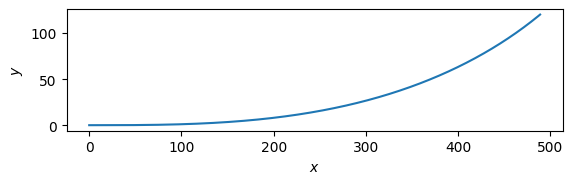

In [7]:
ship_kt.draw_xy_trajectory()

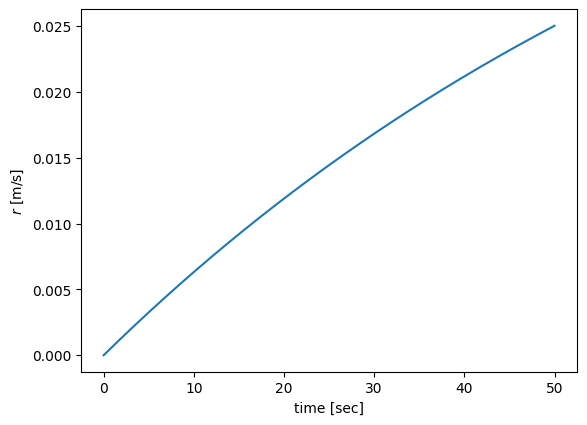

In [8]:
ship_kt.draw_chart(
    "time",
    "r",
    xlabel="time [sec]",
    ylabel=r"$r$" + " [m/s]",
    save_fig_path="u_time_series.png",
)

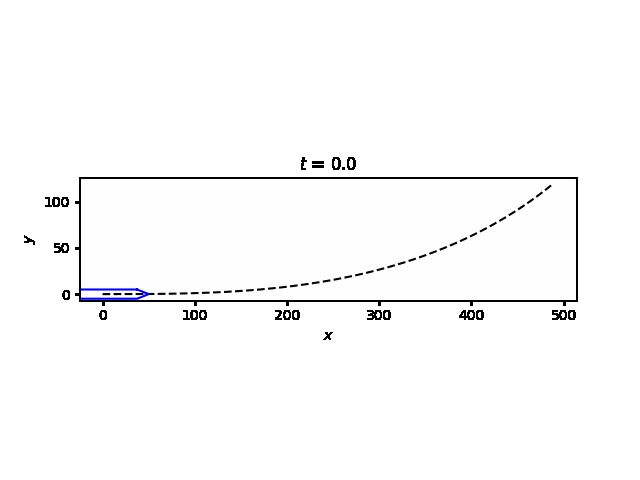

In [9]:
ship_kt.draw_gif(save_fig_path='kt_demo.gif')
from PIL import Image
Image.open('kt_demo.gif')

---
# MMG 3DOF simulation DEMO using KVLCC2 L7 model

## 1. Simulation setting

In [10]:
ρ = 1025.0  # 海水密度

L_pp = 7.00  # 船長Lpp[m]
B = 1.27  # 船幅[m]
d = 0.46  # 喫水[m]
nabla = 3.27  # 排水量[m^3]
x_G = 0.25  # 重心位置[m]
# C_b = 0.810  # 方形係数[-]
D_p = 0.216  # プロペラ直径[m]
H_R = 0.345  # 舵高さ[m]
A_R = 0.0539  # 舵断面積[m^2]

t_P = 0.220  # 推力減少率
w_P0 = 0.40  # 有効伴流率
m_x_dash = 0.022  # 付加質量x(無次元)
m_y_dash = 0.223  # 付加質量y(無次元)
J_z_dash = 0.011  # 付加質量Izz(無次元)
t_R = 0.387  # 操縦抵抗減少率
x_R_dash = -0.500  # 舵の相対位置
a_H = 0.312  # 舵力増加係数
x_H_dash = -0.464  # 舵力増分作用位置
γ_R_minus = 0.395  # 整流係数
γ_R_plus = 0.640  # 整流係数
l_r_dash = -0.710  # 船長に対する舵位置
x_P_dash = -0.480  # 船長に対するプロペラ位置
ϵ = 1.09  # プロペラ・舵位置伴流係数比
κ = 0.50  # 修正係数
f_α = 2.747  # 直圧力勾配係数

basic_params = Mmg3DofBasicParams(
    L_pp=L_pp,  # 船長Lpp[m]
    B=B,  # 船幅[m]
    d=d,  # 喫水[m]
    x_G=x_G,  # 重心位置[]
    D_p=D_p,  # プロペラ直径[m]
    m=ρ * nabla,  # 質量(無次元化)[kg]
    I_zG=ρ * nabla * ((0.25 * L_pp) ** 2),  # 慣性モーメント
    A_R=A_R,  # 船の断面に対する舵面積比
    η=D_p / H_R,  # プロペラ直径に対する舵高さ(Dp/H)
    m_x=(0.5 * ρ * (L_pp ** 2) * d) * m_x_dash,  # 付加質量x(無次元)
    m_y=(0.5 * ρ * (L_pp ** 2) * d) * m_y_dash,  # 付加質量y(無次元)
    J_z=(0.5 * ρ * (L_pp ** 4) * d) * J_z_dash,  # 付加質量Izz(無次元)
    f_α=f_α,
    ϵ=ϵ,  # プロペラ・舵位置伴流係数比
    t_R=t_R,  # 操縦抵抗減少率
    x_R=x_R_dash * L_pp,  # 舵の相対位置
    a_H=a_H,  # 舵力増加係数
    x_H=x_H_dash * L_pp,  # 舵力増分作用位置
    γ_R_minus=γ_R_minus,  # 整流係数
    γ_R_plus=γ_R_plus,  # 整流係数
    l_R=l_r_dash,  # 船長に対する舵位置
    x_P=x_P_dash,  # 船長に対するプロペラ位置
    κ=κ,  # 修正係数
    t_P=t_P,  # 推力減少率
    w_P0=w_P0,  # 有効伴流率
)

k_0 = 0.2931
k_1 = -0.2753
k_2 = -0.1385
R_0_dash = 0.022
X_vv_dash = -0.040
X_vr_dash = 0.002
X_rr_dash = 0.011
X_vvvv_dash = 0.771
Y_v_dash = -0.315
Y_r_dash = 0.083
Y_vvv_dash = -1.607
Y_vvr_dash = 0.379
Y_vrr_dash = -0.391
Y_rrr_dash = 0.008
N_v_dash = -0.137
N_r_dash = -0.049
N_vvv_dash = -0.030
N_vvr_dash = -0.294
N_vrr_dash = 0.055
N_rrr_dash = -0.013

maneuvering_params = Mmg3DofManeuveringParams(
    k_0=k_0,
    k_1=k_1,
    k_2=k_2,
    R_0_dash=R_0_dash,
    X_vv_dash=X_vv_dash,
    X_vr_dash=X_vr_dash,
    X_rr_dash=X_rr_dash,
    X_vvvv_dash=X_vvvv_dash,
    Y_v_dash=Y_v_dash,
    Y_r_dash=Y_r_dash,
    Y_vvv_dash=Y_vvv_dash,
    Y_vvr_dash=Y_vvr_dash,
    Y_vrr_dash=Y_vrr_dash,
    Y_rrr_dash=Y_rrr_dash,
    N_v_dash=N_v_dash,
    N_r_dash=N_r_dash,
    N_vvv_dash=N_vvv_dash,
    N_vvr_dash=N_vvr_dash,
    N_vrr_dash=N_vrr_dash,
    N_rrr_dash=N_rrr_dash,
)

In [11]:
duration = 200  # [s]
# steering_rate = 1.76 * 4  # [°/s]
max_δ_rad = 35 * np.pi / 180.0  # [rad]
n_const = 17.95  # [rpm]

sampling = duration * 10
time_list = np.linspace(0.00, duration, sampling)
δ_rad_list = [0] * sampling
for i in range(sampling):
    δ_rad_list[i] = max_δ_rad

npm_list = np.array([n_const for i in range(sampling)])

## 2. Simulation

In [12]:
sol = simulate_mmg_3dof(
    basic_params,
    maneuvering_params,
    time_list,
    δ_rad_list,
    npm_list,
    u0=2.29 * 0.512,
    v0=0.0,
    r0=0.0,
)
result = sol.sol(time_list)

In [13]:
sol.message

'The solver successfully reached the end of the integration interval.'

## 3. Visualizing by using utility class `ShipObj3dof`

### 3-1. Load simulation result

In [14]:
ship = ShipObj3dof(L=basic_params.L_pp, B=basic_params.B)
ship.load_simulation_result(time_list, result[0], result[1], result[2])

### 3-2. Draw simulation result

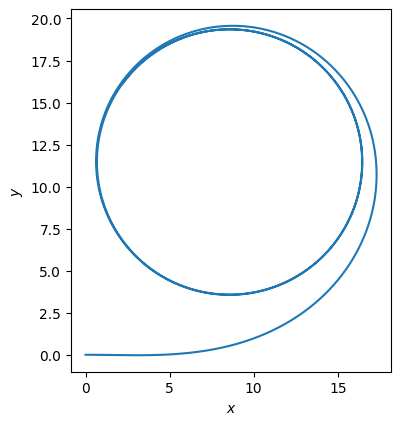

In [15]:
ship.draw_xy_trajectory()

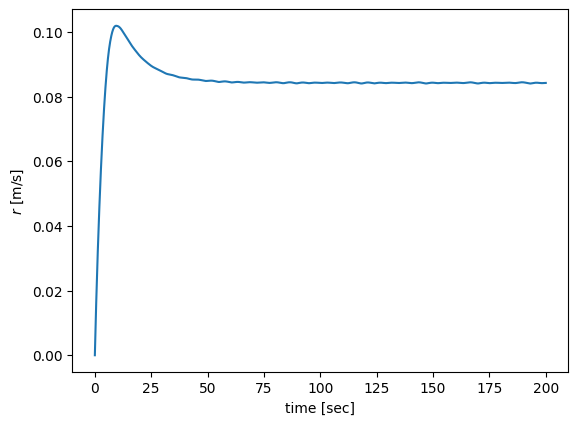

In [16]:
ship.draw_chart(
    "time",
    "r",
    xlabel="time [sec]",
    ylabel=r"$r$" + " [m/s]",
    save_fig_path="u_time_series.png",
)

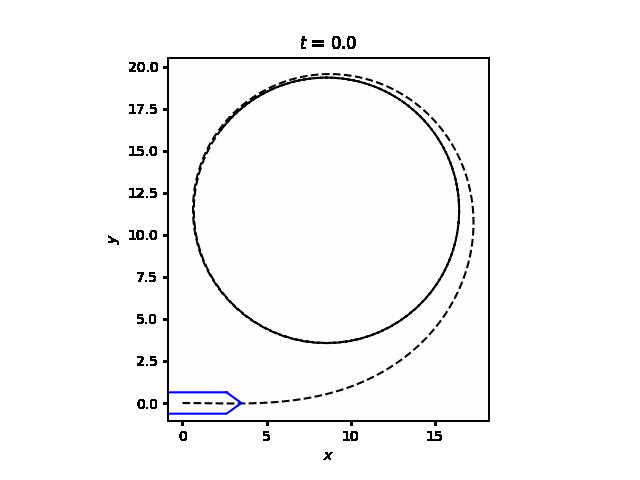

In [17]:
ship.draw_gif(save_fig_path='mmg_3dof_demo1.gif')
from PIL import Image
Image.open('mmg_3dof_demo1.gif')

## Reverse

In [18]:
δ_rad_list = [0] * sampling
for i in range(sampling):
    δ_rad_list[i] = - max_δ_rad

In [19]:
sol = simulate_mmg_3dof(
    basic_params,
    maneuvering_params,
    time_list,
    δ_rad_list,
    npm_list,
    u0=2.29 * 0.512,
    v0=0.0,
    r0=0.0,
)
result = sol.sol(time_list)

In [20]:
ship = ShipObj3dof(L=basic_params.L_pp, B=basic_params.B)
ship.load_simulation_result(time_list, result[0], result[1], result[2])

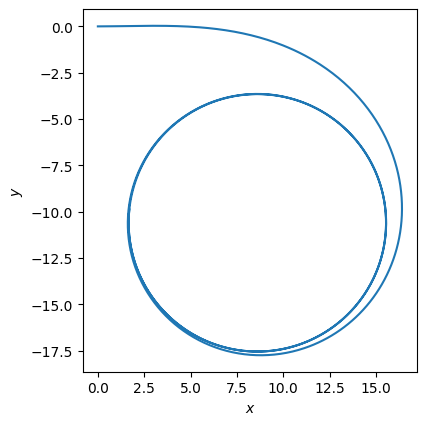

In [21]:
ship.draw_xy_trajectory()

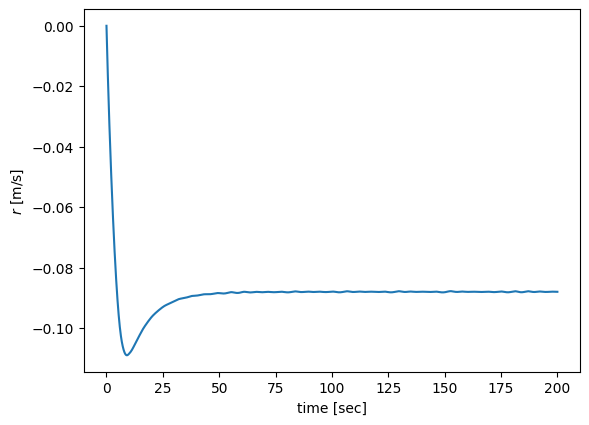

In [22]:
ship.draw_chart(
    "time",
    "r",
    xlabel="time [sec]",
    ylabel=r"$r$" + " [m/s]",
    save_fig_path="u_time_series.png",
)

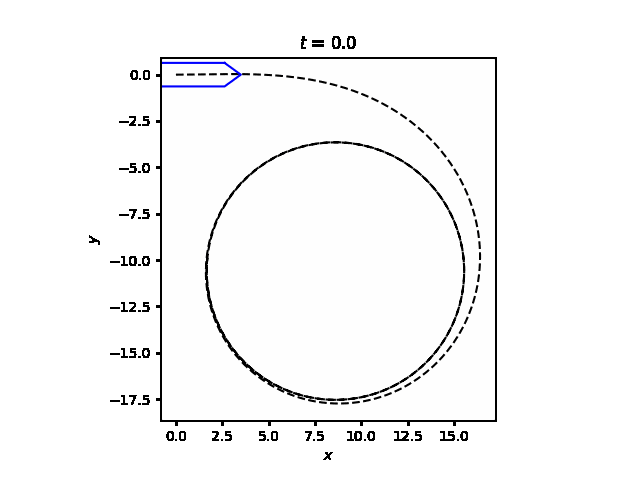

In [23]:
ship.draw_gif(save_fig_path='mmg_3dof_demo2.gif')
from PIL import Image
Image.open('mmg_3dof_demo2.gif')

## Zig-Zag

In [24]:
target_δ_rad = -10.0 * np.pi / 180.0
target_ψ_rad_deviation = 10.0 * np.pi / 180.0
duration = 100
num_of_sampling = 10000
time_list = np.linspace(0.00, duration, num_of_sampling)
n_const = 17.95  # [rpm]
npm_list = np.array([n_const for i in range(num_of_sampling)])

δ_list, u_list, v_list, r_list = zigzag_test_mmg_3dof(
    basic_params,
    maneuvering_params,
    target_δ_rad,
    target_ψ_rad_deviation,
    time_list,
    npm_list,
    δ_rad_rate=10.0 * np.pi / 180,
)

ship = ShipObj3dof(L=100, B=10)
ship.load_simulation_result(time_list, u_list, v_list, r_list)
ship.δ = δ_list
ship.npm = npm_list

### OUTPUT

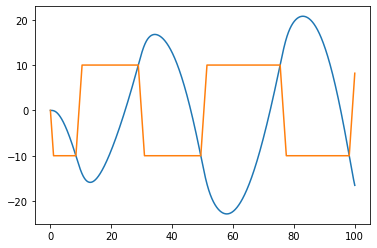

In [25]:
import matplotlib.pyplot as plt
plt.plot(time_list, list(map(lambda psi: psi * 180 / np.pi, ship.psi)))
plt.plot(time_list, list(map(lambda δ: δ * 180 / np.pi, ship.δ)))

In [26]:
(
    X_H_list,
    X_R_list,
    X_P_list,
    Y_H_list,
    Y_R_list,
    N_H_list,
    N_R_list,
    U_list,
    β_list,
    v_dash_list,
    r_dash_list,
    β_P_list,
    w_P_list,
    J_list,
    K_T_list,
    β_R_list,
    γ_R_list,
    v_R_list,
    u_R_list,
    U_R_list,
    α_R_list,
    F_N_list,
) = get_sub_values_from_simulation_result(
    ship.u,
    ship.v,
    ship.r,
    ship.δ,
    ship.npm,
    basic_params,
    maneuvering_params,
    return_all_vals=True,
)

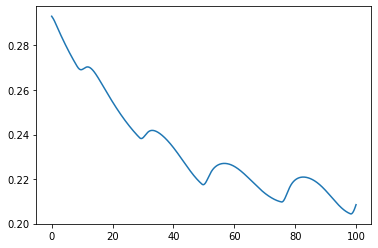

In [27]:
plt.plot(time_list,K_T_list)

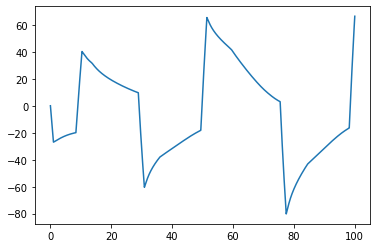

In [28]:
plt.plot(time_list,F_N_list)

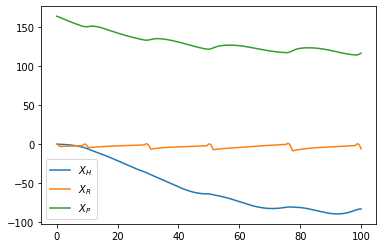

In [29]:
plt.plot(time_list,X_H_list, label=r"$X_H$")
plt.plot(time_list,X_R_list, label=r"$X_R$")
plt.plot(time_list,X_P_list, label=r"$X_P$")
plt.legend();

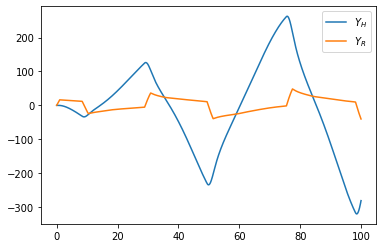

In [30]:
plt.plot(time_list,Y_H_list, label=r"$Y_H$")
plt.plot(time_list,Y_R_list, label=r"$Y_R$")
plt.legend();

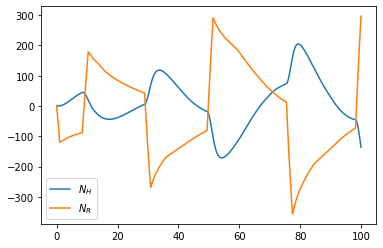

In [31]:
plt.plot(time_list,N_H_list, label=r"$N_H$")
plt.plot(time_list,N_R_list, label=r"$N_R$")
plt.legend();